# Training a `scikit-learn` model

In [89]:
# !pip install scikit-learn

## Computing features

In [1]:
import sys
import os
sys.path.append(os.path.join(os.curdir, ".."))
# sys.path

In [2]:
from graphdatascience import GraphDataScience
from sklearn.utils import resample
from sklearn import tree
from sklearn.model_selection import train_test_split

from utils import create_projected_graph

In [3]:
gds = GraphDataScience("bolt://localhost:7687", auth=("neo4j", "admin"))

In [6]:
projected_graph_object = create_projected_graph(
    gds,
    graph_name="pgraphB",
    node_spec="NodeB",  
    relationship_spec={"LINK": {"orientation": "UNDIRECTED"}}
)

In [7]:
gds.louvain.write(
    projected_graph_object,
    writeProperty="louvain"
)

Louvain:   0%|          | 0/100 [00:00<?, ?%/s]

writeMillis                                                            207
nodePropertiesWritten                                                  800
modularity                                                        0.435427
modularities                     [0.4349884322245381, 0.43542650313630066]
ranLevels                                                                2
communityCount                                                           4
communityDistribution    {'p99': 350, 'min': 100, 'max': 350, 'mean': 2...
postProcessingMillis                                                    10
preProcessingMillis                                                      0
computeMillis                                                          477
configuration            {'maxIterations': 10, 'writeConcurrency': 4, '...
Name: 0, dtype: object

In [5]:
gds.graph.drop(projected_graph_object)

graphName                                                      pgraphB
database                                                         neo4j
memoryUsage                                                           
sizeInBytes                                                         -1
nodeCount                                                          800
relationshipCount                                                41454
configuration        {'relationshipProjection': {'LINK': {'orientat...
density                                                       0.064853
creationTime                       2022-08-23T14:41:55.806133000+02:00
modificationTime                   2022-08-23T14:41:55.812809000+02:00
schema               {'graphProperties': {}, 'relationships': {'LIN...
Name: 0, dtype: object

## Extracting data into a dataframe

In [216]:
data = gds.run_cypher(
    """MATCH (node:NodeB)
    RETURN node.id as id, node.feature as feature, node.louvain as louvain, node.target as target
    """
)
data.head()

,id,feature,louvain,target
0,0,0.361725,13,0
1,1,0.146373,13,0
2,2,1.079857,13,0
3,3,-1.407586,13,0
4,4,0.830645,13,1


In [217]:
data.target.value_counts()

0    427
1    373
Name: target, dtype: int64

In [219]:
true_data = data[data.target == 1]
false_data = data[data.target == 0]
len(true_data), len(false_data)

(373, 427)

In [220]:
false_data_downsampled = resample(
    false_data,
    replace=True,
    n_samples=len(true_data),
    random_state=1234,
)

In [223]:
data = pd.concat([true_data, false_data_downsampled], axis=0)
data.target.value_counts()

1    373
0    373
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

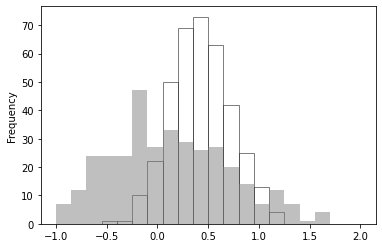

In [249]:
true_data.feature.plot.hist(range=(-1, 2), bins=20, color="white", edgecolor="black", alpha=0.5)
false_data_downsampled.feature.plot.hist(range=(-1, 2), bins=20, color="grey", alpha=0.5)


In [231]:
def train_and_score(X_train, y_train, X_test, y_test, feature_columns):
    X_train_bis = X_train[feature_columns]
    X_test_bis = X_test[feature_columns]
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train_bis, y_train)
    return clf.score(X_test_bis, y_test)

In [250]:
X = data[["feature", "louvain"]]
y = data.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33,
    stratify=data.target,
    random_state=1234
)
len(X_train), len(X_test)

(499, 247)

In [251]:
feature_sets = [
   ["feature"],
   ["louvain"],
   ["feature", "louvain"],
]

for feature_set in feature_sets:
    score = train_and_score(
        X_train, y_train, X_test, y_test, 
        feature_set
    )
    print(f"{str(feature_set):30} => {score:2.2f}")

['feature']                    => 0.72
['louvain']                    => 0.77
['feature', 'louvain']         => 0.80


<AxesSubplot:ylabel='Frequency'>

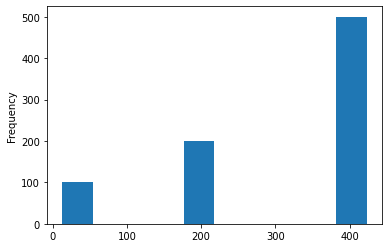

In [10]:
data.louvain.plot.hist()

In [12]:
data.louvain.value_counts()

423    350
210    200
418    150
13     100
Name: louvain, dtype: int64

In [13]:
target_map = {
    u: k for k , u in enumerate(data.louvain.unique())
}
target_map

{13: 0, 210: 1, 418: 2, 423: 3}

In [14]:
data["target"] = data.louvain.map(target_map)

<AxesSubplot:ylabel='Frequency'>

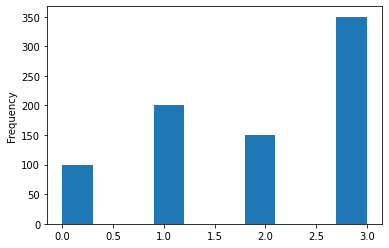

In [15]:
data.target.plot.hist()

<AxesSubplot:ylabel='Frequency'>

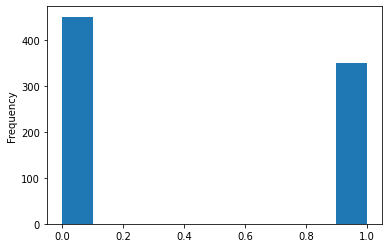

In [17]:
data["target_0"] = (data.target == 3).astype(int)
data.target_0.plot.hist()

In [178]:
keep_mask = np.random.random(size=len(data)) > 0.2
data["target_1"] = (
    data["target_0"] * keep_mask
    + (np.invert(data["target_0"]) + 2) * (1 - keep_mask)
)

<AxesSubplot:ylabel='Frequency'>

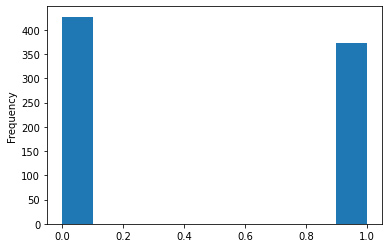

In [179]:
data.target_1.plot.hist()

In [180]:
data.target_1.value_counts()

0    427
1    373
Name: target_1, dtype: int64

In [181]:
data.target_0.value_counts()

0    450
1    350
Name: target_0, dtype: int64

In [182]:
from sklearn import tree
from sklearn.model_selection import train_test_split

X = data[["louvain"]]
Y = data["target_1"]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)
clf.score(X_test, Y_test)

0.8106060606060606

<AxesSubplot:ylabel='Frequency'>

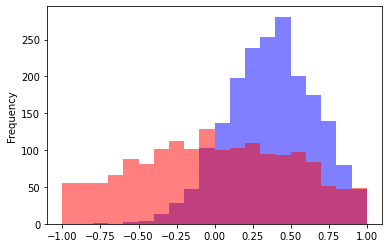

In [183]:
feature1 = np.random.normal(size=2000, scale=0.3, loc=0.4)
feature2 = np.random.normal(size=2000, scale=0.7, loc=0)

pd.Series(feature1).plot.hist(range=(-1, 1), bins=20, color="blue", alpha=0.5)
pd.Series(feature2).plot.hist(range=(-1, 1), bins=20, color="red", alpha=0.5)

In [184]:
data["feature"] = None

In [185]:
column = "target_1"
value = 1
params = {
    "scale": 0.3,
    "loc":0.4
}
mask = data[column] == value
data.loc[mask, "feature"] = np.random.normal(
    size=sum(mask), 
    **params
)

In [186]:
column = "target_1"
value = 0
params = {
    "scale": 0.7,
    "loc":0
}
mask = data[column] == value
data.loc[mask, "feature"] = np.random.normal(
    size=sum(mask), 
    **params
)

In [187]:
data

,id,louvain,target,target_0,target_1,tmp,feature
0,0,13,0,0,0,-1,0.361725
1,1,13,0,0,0,-1,0.146373
2,2,13,0,0,0,-1,1.079857
3,3,13,0,0,0,-1,-1.407586
4,4,13,0,0,1,-1,0.830645
...,...,...,...,...,...,...,...
795,797,423,3,1,1,-2,-0.075665
796,787,423,3,1,1,-2,0.691105
797,794,423,3,1,0,-2,-1.058544
798,798,423,3,1,1,-2,0.160159


In [190]:
from sklearn.utils import resample
df = resample(
    data,
    replace=True,
    n_samples=len(data[data.target_1 == 1]),
    random_state=1234,
)

In [193]:
from sklearn import tree
from sklearn.model_selection import train_test_split

X = df[["louvain"]]
Y = df["target_1"]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)
print(clf.score(X_test, Y_test))

0.7741935483870968


In [191]:
from sklearn import tree
from sklearn.model_selection import train_test_split

X = df[["feature"]]
Y = df["target_1"]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)
print(clf.score(X_test, Y_test))

0.75


In [192]:
from sklearn import tree
from sklearn.model_selection import train_test_split

X = df[["feature", "louvain"]]
Y = df["target_1"]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)
print(clf.score(X_test, Y_test))

0.8467741935483871


In [195]:
data.to_csv("dataset.csv", index=False)